In [1]:
import cpm
from packaging import version

## cpm checks
print(cpm.__version__)
if version.parse(cpm.__version__) < version.parse("0.22"):
    raise ImportError("cpm version must be >= 0.22. Please install the latest version using: pip install --upgrade cpm")

0.23.0


# EXERCISE 2

Evaluating how well the model recovers the original parameters. Briefly, you will sample a random set of model parameters, generate new data, fit the model to the data, and then compare the estimated parameters to the original ones. This will require some modification to the code you wrote in Exercise 1. Specifically, instead of using the participant's choice to select what value to update, you will take the model's probability of choosing each option and use that to sample a choice. The technique we will use below will also involve two new additions to our model: the _loss function_ and the _Bernoulli distribution function_ to generate data. So, what will you do here?

2. Estimate the parameter recovery of the model
    1. Generate data from the model
    2. Fit the model to the data
    3. Compare the estimated parameters to the true parameters


## Discrepency function (Negative Log Likelihood)

Here, we define the loss function based on negative log likelihood.

\begin{align*}
-\log L(\theta \mid Y, M) = -\sum_{i=1}^{N} \log \bigg[ p(y_i \mid \theta) \bigg]
\end{align*}

where $\theta$ are model parameters, $Y$ is the data with $N$ number of data points, and $M$ is the model. The $p(y~|~\theta)$ gives the probability of observing the data given a certain parameter set. It follows a _Bernoulli_ distribution and defined such as:


\begin{align*}
p(y_t~|~\theta) = \left\{ \begin{array}{ll} P(a_t) &
\text{if } y = 1, \text{ and} \\ 1 - P(a_t) & \text{if } y = 0.
\end{array} \right.
\end{align*}

Note that the loss function is not part of our model specification, but is implemented as `cpm.optimistaion.minimisation.LogLikelihood.bernoulli`. If the number of actions participants can take on a given trial is greater than one, we can exchange it for a loss function `LogLikelihood.categorical` without the need to modify the implementation of a model.

## Generating data with the model

To generate data with the model, we will use the same _Bernoulli distribution_, with its mean given by the model's probability of choosing each option. The SoftMax function we defined previously will return a probability for each action, and we will sample from this distribution to generate a choice. This is done using the `cpm.models.decision.SoftMax.choice()`. function.


## EXERCISE 2.1: modify your model, generate data with random parameters

In [10]:
import numpy
import pandas as pd
import cpm
import cpm.datasets as datasets
from cpm.generators import Parameters, Value
import ipyparallel as ipp  # for parallel computing with ipython (specific for Jupyter Notebook)

data = datasets.load_bandit_data()
data.head()

parameters = Parameters(
    # free parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.5, "sd": 0.25},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": 5, "sd": 2.5},
    ),
    # everything without a prior is part of the initial state of the
    # model or constructs fixed throughout the simulation
    # (e.g. exemplars in general-context models of categorizations)
    # initial q-values starting starting from non-zero value
    # these are equal to all 4 stimuli (1 / 4)
    values = numpy.array([0.25, 0.25, 0.25, 0.25])
    )

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    model_choices = choice_rule.choice()  # get the model's choice
    # get the received reward for the choice
    reward = feedback[model_choices]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[model_choices] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        "response" : model_choices,          # model's choice
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

# EXERCISE 2.2: generate data with random parameters

Her, you need to generate a random set of parameters, equal in number to the number of participants in your data set. Then, you will use the `cpm.generators.Simulator` class to generate data for the whole sample.

In [11]:
generative_model = cpm.generators.Wrapper(
    model=model,
    parameters=parameters,
    data=data[data.ppt == 1],
)

In [ ]:
number_of_participants = data.ppt.nunique()
parameters_for_the_whole_sample = parameters.sample(size=number_of_participants)
original_parameters = pd.DataFrame(parameters_for_the_whole_sample) ## save the original parameters
original_parameters["ppt"] = data.ppt.unique()

# create a simulator that will run the model for each participant
simulator = cpm.generators.Simulator(
    wrapper=generative_model,
    data=data.groupby("ppt"),
    parameters=parameters_for_the_whole_sample,
)
simulator.run()
# collect the results
results = simulator.export()
results.head()

,trial_0,activation_0,activation_1,policy_0,policy_1,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,response_0,dependent_0,ppt
0,1,0.250000,0.250000,0.500000,0.500000,1,0.000000,0.000000,0.0,0.479577,0.250000,0.250000,0.25,0.729577,1,0.500000,1
1,2,0.250000,0.729577,0.131446,0.868554,1,0.000000,0.000000,0.0,0.172918,0.250000,0.250000,0.25,0.902495,1,0.868554,1
2,3,0.250000,0.250000,0.500000,0.500000,0,-0.000000,-0.159859,-0.0,-0.000000,0.250000,0.090141,0.25,0.902495,0,0.500000,1
3,4,0.090141,0.250000,0.347644,0.652356,0,-0.159859,-0.000000,-0.0,-0.000000,0.090141,0.090141,0.25,0.902495,1,0.652356,1
4,5,0.090141,0.902495,0.039223,0.960777,0,-0.000000,-0.000000,-0.0,-0.577087,0.090141,0.090141,0.25,0.325408,1,0.960777,1


All that is left from the simulations is to take the model output and create our dependent variable for the fitting. The toolbox requires the data to contain a single column with the `dependent variable`, that we are estimating model performance against. In this case, the dependent variable is the choice made by the model, which is a binary variable (0 or 1) indicating whether the model chose option 1 or option 2. We take that from the `Simulator` output and create a new column in the data frame.


In [ ]:
recovery_data = data.copy() ## copy the original data
recovery_data["observed"] = results["response_0"] ## select the variable of interest
recovery_data["response"] = results["response_0"] ## select the model's response

recovery_data.head() ## print the first few rows of the data to check

,ppt,trial,arm_left,arm_right,reward_left,reward_right,response,feedback,observed
0,1,1,2,4,1,1,1,1,1
1,1,2,2,4,1,1,1,1,1
2,1,3,2,1,0,0,0,0,0
3,1,4,2,1,0,0,1,0,1
4,1,5,1,4,0,0,1,0,1


## EXERCISE 2.2: fit the model to the data

## EXERCISE 2.2.1: revert the model to the original version

So, we need to revert the model to the original version, which means removing the `choice` argument from the code we wrote before. This will allow us to fit the model to the data generated in Exercise 2.2. as opposed to generating new data.

In [14]:
@ipp.require("numpy")
def model_fitting(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.observed.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

In [15]:
base_model = cpm.generators.Wrapper(
    model=model_fitting,
    parameters=parameters,
    data=recovery_data[recovery_data.ppt == 1],
)

Now that we have everything ready, we can fit the model to the data. We will use the `cpm.optimisation.FminBound` class to do that. The fitting process will return a set of estimated parameters for each participant, which we can then compare to the original parameters.

In [16]:
from cpm.optimisation import minimise, FminBound
# Set up the fitting procedure
fit = FminBound(
    model=base_model,  # Wrapper class with the model we specified from before
    data=recovery_data.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.37334317 3.99363461]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 2/5 from [0.77382538 8.00881882]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 3/5 from [0.1933738  6.65288518]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 4/5 from [0.04959636 3.21374008]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 5/5 from [0.11435742 8.13742939]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

## EXERCISE 2.3: compare the estimated parameters with the original ones

In [17]:
recovered_parameters = fit.export()
recovered_parameters.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)
recovered_parameters.head()

,alpha,temperature,grad_0,grad_1,task,funcalls,nit,warnflag,hessian_0,hessian_1,hessian_2,hessian_3,ppt,fun
0,0.717602,5.103572,1.563194e-04,-1.065814e-05,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,42,12,0,54.431625,-0.465532,-0.465532,0.673057,1,38.496652
1,0.142981,4.120136,0.000000e+00,1.421085e-06,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,54,13,0,191.486741,8.720288,8.720288,1.233973,2,51.264174
2,0.420720,5.690293,4.263256e-06,7.105427e-07,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,33,9,0,127.232686,1.975052,1.975052,0.638376,3,37.539248
3,0.753031,2.904578,1.207923e-05,2.842171e-06,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,57,12,0,44.658930,4.180839,4.180839,2.592969,4,47.345928
4,0.289077,6.065746,7.105427e-07,0.000000e+00,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,48,13,0,76.854948,3.858814,3.858814,0.793781,5,32.901903


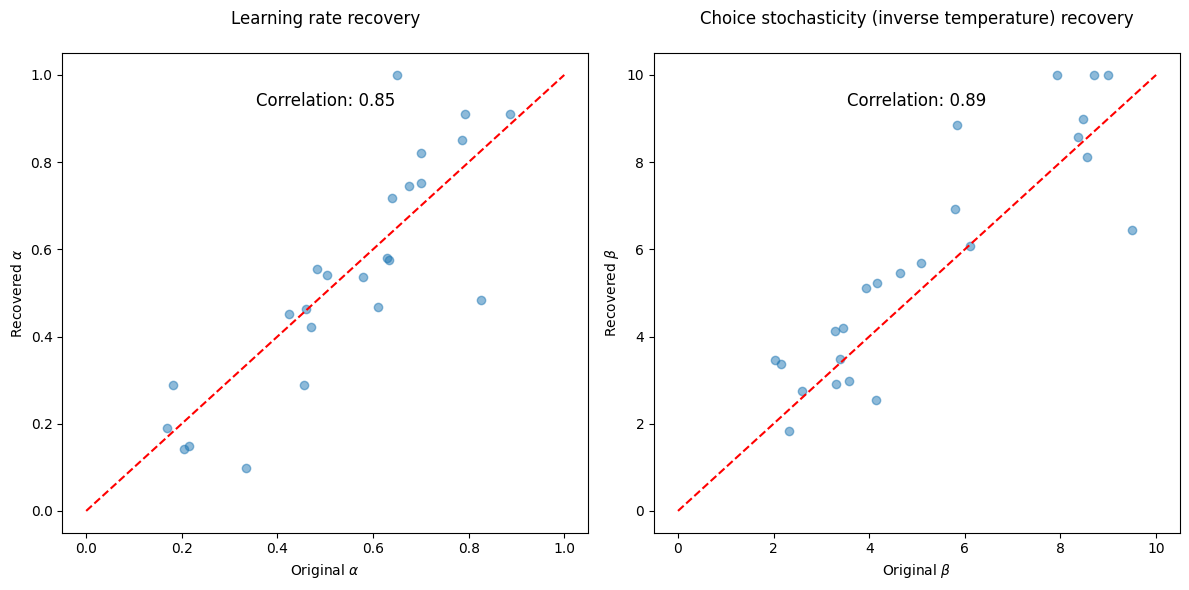

In [ ]:
import matplotlib.pyplot as plt

alpha_original = original_parameters["alpha"].values
alpha_recovered = recovered_parameters["alpha"].values
beta_original = original_parameters["temperature"].values
beta_recovered = recovered_parameters["temperature"].values
# Plotting the results

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

## scatterplots
axes[0].scatter(alpha_original, alpha_recovered, alpha=0.5)
## add correlation coefficient
corr_alpha = numpy.corrcoef(alpha_original, alpha_recovered)[0, 1]
axes[0].text(0.5, 0.9, f'Correlation: {corr_alpha:.2f}', transform=axes[0].transAxes, fontsize=12, ha='center', va='center')
axes[0].set_xlabel(r'Original $\alpha$')
axes[0].set_ylabel(r'Recovered $\alpha$')
axes[0].set_title('Learning rate recovery\n')
axes[0].plot([0, 1], [0, 1], 'r--')  # Diagonal line for reference
axes[1].scatter(beta_original, beta_recovered, alpha=0.5)
## add correlation coefficient
corr_beta = numpy.corrcoef(beta_original, beta_recovered)[0, 1]
axes[1].text(0.5, 0.9, f'Correlation: {corr_beta:.2f}', transform=axes[1].transAxes, fontsize=12, ha='center', va='center')
axes[1].set_xlabel(r'Original $\beta$')
axes[1].set_ylabel(r'Recovered $\beta$')
axes[1].set_title('Choice stochasticity (inverse temperature) recovery\n')
axes[1].plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
# Adjust layout and show the plot
plt.tight_layout()

# Questions

- What do you think about the results of the parameter recovery? Are the parameters identifiable?
- Are there any parameters that are not identifiable? If so, why do you think that is the case?
